---
---
# Few-Shot Learning for Object Recognition in Cultural Sites:<br>Filtraggio Dataset “Monastero dei Benedettini”
---
---

# Introduzione
---
\
Nell’ambito del Machine Learning, l’**Object Recognition** è una tecnica che consiste nell'identificare oggetti in immagini o video. L'obiettivo è quindi di insegnare ad un computer ciò che l'uomo fa quotidinamente: capire quale oggetto è contenuto nell'immagine.

![alt text](https://www.mathworks.com/solutions/image-video-processing/object-recognition/_jcr_content/mainParsys/band_copy_1227855798_2052140687/mainParsys/columns_1606542234/2/image_copy_copy_copy.adapt.full.high.svg/1561120808359.svg)

Esistono approcci all'Object Recognition tramite Machine Learning e Deep Learning. Gli algoritmi di Deep Learning per Object Recognition richiedono una fase di training su migliaia di immagini etichettate al fine di apprendere una rappresentazione capace di separare spazialmente un certo numero di oggetti da riconoscere.

![alt text](https://www.mathworks.com/solutions/image-video-processing/object-recognition/_jcr_content/mainParsys/band_copy_copy_14735_1351083864/mainParsys/columns_1606542234_c_136129954/2/image_copy_copy_copy.adapt.full.high.svg/1561120809600.svg)

L’obiettivo del **Few-Shot Learning** è cercare di apprendere una rappresentazione ed una metrica tale che sia possibile distinguere oggetti diversi avendo poche immagini di questi ultimi.

# Obbiettivo
---
\
L'obbiettivo fissato per questo progetto è quello di migliorare la qualità di un dataset, analizzandolo e filtrandolo, al fine di aumentare le performance ottenute applicando il Few-Shot Learning. Il dataset scelto per questo progetto,
scaricabile facendo richiesa tramite il seguente [link](https://iplab.dmi.unict.it/EGO-CH/), è relativo al Sito Culturale "*Monastero dei Benedettini*" sito in Catania.

![alt text](https://iplab.dmi.unict.it/EGO-CH/img/dataset.png)

# Analisi e filtraggio del dataset
---
\
![alt text](https://www.synarea.com/mindset/images/components/full/analytics.jpg)

Effettueremo l'analisi ed il filtraggio del dataset "*Monastero dei Benedettini*" usando il servizio online *Google Colab*.<br>
Per questo motivo come prima cosa è necessario caricare il dataset in *Google Drive* (preferibilmente in formato compresso e.g .tar, .zip, ..), successivamente montare nel file system della macchina remota la cartella root di *Google Drive*, ed infine copiare e decomprimere il dataset.

![alt text](https://cdn-images-1.medium.com/max/1000/1*Lad06lrjlU9UZgSTHUoyfA.png)

In [0]:
!cp "drive/My Drive/Datasets/BellomoBenedettini/Dataset.tar" dataset.tar

In [0]:
!tar -xf dataset.tar

Troveremo il dataset "*Monastero dei Benedettini*" nel path `dataset/Object Retrieval/Monastero dei Benedettini/`.<br>
Il dataset è fornito con la seguente struttura:


```
dataset/
└── Object Retrieval/
    ├── README.txt
    ├── Monastero dei Benedettini/
    │   ├── labels.txt
    │   ├── Test/
    │   │   ├── 100/
    │   │   │   ├── 000009_0.jpg
    │   │   │   ├── ...
    │   │   │   └── 001339.jpg
    │   │   ├── .../
    │   │   │   └── ...
    │   │   ├── 166/
    │   │   │   └── ...
    │   │   ├── bbox_annotations/
    │   │   │   └── ...
    │   │   └── labels/
    │   │       ├── 100.txt
    │   │       ├── ...
    │   │       └── 166.txt
    │   └── Training/
    │       ├── 5.1_Porta Aula Santo Mazzarino.jpg
    │       ├── ...
    │       └── 8.9_Pozzo.jpg
    └── Palazzo Bellomo/
        └── ...
```

Il file `dataset/Object Retrieval/Monastero dei Benedettini/labels.txt` contiene **35 etichette numeriche** da associare alle immagini support contenute in `dataset/Object Retrieval/Monastero dei Benedettini/Training/`. Quest'ultima cartella infatti, contiene le **35 immagini** di riferimento del Sito Culturale.<br>
La cartella `dataset/Object Retrieval/Monastero dei Benedettini/Test/` contiene invece **62 cartelle** con numerazione da **100** a **166** (N.B. alcuni valori sono mancanti), nelle quali sono contenute un numero variabile di immagini target ciascuna appartenende ad una delle 35 classi. La corretta classe da associare a ciascuna delle immagini contenute all'interno della cartella "*Test*" viene assegnata andando a guardare i file "`.txt`" contenuti nella relativa sotto-cartella contenuta in `dataset/Object Retrieval/Monastero dei Benedettini/Test/labels/`<br>
Per caricare il dataset definiamo quindi due metodi:
- `createSupportDataFrame` :<br>
Il metodo prende in input la cartella in cui sono contenute tutte le immagini support (`dataset/Object Retrieval/Monastero dei Benedettini/Training/`) e il file contenente le etichette da associare a ciascuna immagine (`dataset/Object Retrieval/Monastero dei Benedettini/labels.txt`) e ritorna un `DataFrame` con attributi (`Support Path`, `Class`) tramite il quale è possibile associare ad ogni path dell'immagine support, l'etichetta relativa alla classe rappresentata.
- `createTargetDataFrame` :<br>
Il metodo prende in input la cartella in cui sono contenute tutte le immagini target (`dataset/Object Retrieval/Monastero dei Benedettini/Test/`) e ritorna un `DataFrame` con attributi (`Target Path`, `Class`, `Support Path`) tramite il quale è possibile associare ad ogni path dell'immagine target, l'etichetta relativa alla classe di appartenenza basandosi sui file in `dataset/Object Retrieval/Monastero dei Benedettini/Test/labels/` ed inoltre risalire all'immagine della classe di riferimento.

In [0]:
dataset_path = "dataset/Object Retrieval/Monastero dei Benedettini/"
dataset_targets_path = dataset_path+"Test/"
dataset_supports_path = dataset_path+"Training/"

In [0]:
import numpy as np
import pandas as pd
from numpy import genfromtxt
from os import listdir, path

def createSupportDataFrame(support_dir, labels_dir):
    labels = genfromtxt(path.join(labels_dir, 'labels.txt'), delimiter='\t').tolist()
    labels = labels[1:] # drop field names
    labels = [[str(label[0]), int(label[1])] for label in labels]
    labels[-2] = ['8.10', labels[-2][1]]
    labels_dict = {int(a) : b for b,a in labels}
    
    support_dict = {}
    for key, value in labels_dict.items():
        support_dict[key] = [filename for filename in listdir(support_dir) if filename.startswith(str(value)+"_")][0]
    
    dataset_supports_df = pd.DataFrame(pd.Series(support_dict, name="Support Path"))
    dataset_supports_df['Class'] = np.arange(35)
    return dataset_supports_df

def createTargetDataFrame(target_dir, support_dir, dataset_supports_df=None):
  target_list = []
  for i in range(100, 167):
    try:
        images_dir = path.join(target_dir, str(i))
        target_labels = genfromtxt(path.join(target_dir, 'labels/%d.txt' % i))
        target_images = listdir(images_dir)
        target_images.sort()

        if len(target_labels) != len(target_images):
            print(i, "error labels and images num are not the same!", len(target_labels), len(target_images))
            raise Exception

        for index, target_path in enumerate(target_images):
            target_img_path = path.join(target_dir, str(i), target_path)
            target_class = int(target_labels[index])
            if not dataset_supports_df.empty:
              support_img_path = path.join(support_dir, dataset_supports_df.loc[target_class]['Support Path'])
              target_list.append((target_img_path, target_class, support_img_path))
            else:
              target_list.append((target_img_path, target_class))

    except Exception as e:
        pass
  
  dataset_targets_df = pd.DataFrame(target_list)
  if not dataset_supports_df.empty:
    dataset_targets_df.columns = ("Target Path", "Class", "Support Path")
  else:
    dataset_targets_df.columns = ("Target Path", "Class")

  return dataset_targets_df

In [5]:
dataset_supports_df = createSupportDataFrame(dataset_supports_path, dataset_path)
print("len: %s" % len(dataset_supports_df))
dataset_supports_df

len: 35


Support Path  Class
0                  5.1_Porta Aula Santo Mazzarino.jpg      0
1   5.2_Porta d'ingresso al Museo della Fabbrica d...      1
2                        5.3_Porta Antirefettorio.jpg      2
3      5.4_Porta d'ingresso al Refettorio Piccolo.jpg      3
4                  5.5_Cupola dell'Antirefettorio.jpg      4
5                          5.6_Apertura pavimento.jpg      5
6                           5.7_Scultura S. Agata.jpg      6
7                      5.8_Scultura S. Scolastica.jpg      7
8                      6.1_Quadro Santo Mazzarino.jpg      8
9            6.2_Affresco Il Trionfo di Benedetto.jpg      9
10                        6.3_Pavimento originale.jpg     10
11                       6.4_Pavimento restaurato.jpg     11
12                      6.5_Bassorilievi mancanti.jpg     12
13                          6.6_Lavamani sinistro.jpg     13
14                            6.7_Lavamani destro.jpg     14
15                        6.8_Tavolo dei Relatori.jpg     15
16                                   6.9_Poltrone.jpg     16
17                                    7.1_Edicola.jpg     17
18                                7.2_Pavimento A.jpg     18
19                                7.3_Pavimento B.jpg     19
20       7.4_Passavivande con pavimento originale.jpg     20
21                         7.5_Aperture pavimento.jpg     21
22                                      7.6_Scala.jpg     22
23                         7.7_Sala meteorologica.jpg     23
24                                   8.1_Doccione.jpg     24
25                       8.2_Vano raccolta cenere.jpg     25
26                                 8.3_Sala Rossa.jpg     26
27                      8.4_Scala verso la cucina.jpg     27
28                         8.5_Cucina provvisoria.jpg     28
29                                 8.6_Ghiacciaia.jpg     29
30                                    8.7_Latrina.jpg     30
31                   8.8_Ossa e scarti di fornace.jpg     31
32                                      8.9_Pozzo.jpg     32
33                                  8.10_Cisterna.jpg     33
34                     8.11_Busto Pietro Tacchini.jpg     34

In [6]:
dataset_targets_df = createTargetDataFrame(dataset_targets_path, dataset_supports_path, dataset_supports_df)
print("len: %s" % len(dataset_targets_df))
dataset_targets_df

len: 44978


Target Path  ...                                       Support Path
0      dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
1      dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
2      dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
3      dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
4      dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
...                                                  ...  ...                                                ...
44973  dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
44974  dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
44975  dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
44976  dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
44977  dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...

[44978 rows x 3 columns]

A questo punto avremo i percorsi di ciascuna immagine del dataset e la relativa classe di appartenenza.<br>
Dai dati caricati notiamo che il dataset "*Monastero dei Benedettini*" consiste in un totale di **44978 immagini target** appartenenti a **35 classi**.<br>
Illustreremo adesso tramite grafici e tabella la numerosità di ciascuna classe del dataset "*Monastero dei Benedettini*"

In [0]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
def frequencyPlot(data, title="", bar_labels=("",""), bar_labelrotation=0, ytick_major_step=500, ytick_minor_step=250, ytick_labels=None, max_val=None):
    ax1 = data.plot.bar(figsize=(20,13))
    plt.title(title)

    if not max_val:
        max_val = np.max(data.values)+5
    ax1.set_yticks(np.arange(0, max_val, ytick_major_step))
    ax1.set_yticks(np.arange(0, max_val, ytick_minor_step), minor=True)
    if ytick_labels:
      ax1.set_yticklabels(labels = ytick_labels)      
    ax1.yaxis.grid(which='major', color='#555555', linestyle='-', alpha=0.5)
    ax1.yaxis.grid(which='minor', color='#AAAAAA', linestyle=':', alpha=0.9)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=bar_labelrotation)
    
    plt.xlabel(bar_labels[0])
    plt.ylabel(bar_labels[1])
        
    plt.tight_layout()    
    plt.show()

In [8]:
original_dataset_class_samples_count_df = dataset_targets_df["Class"].value_counts().sort_index().to_frame('Class original samples count')
original_dataset_class_samples_count_df.transpose()

0    1    2    3   ...    31   32    33    34
Class original samples count  769  207  276  148  ...  1083  568  1760  1024

[1 rows x 35 columns]

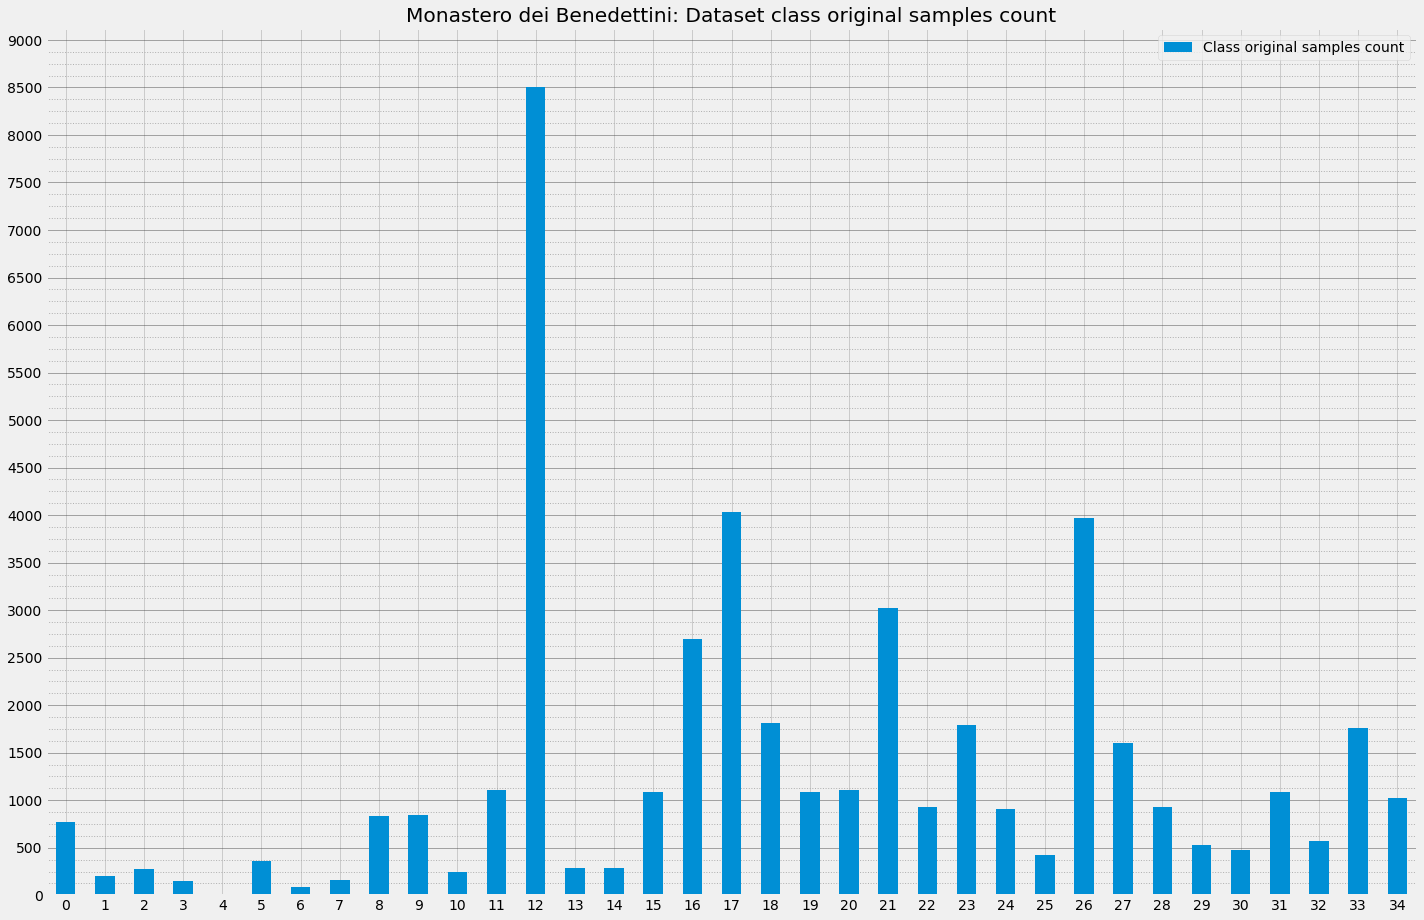

In [9]:
frequencyPlot(
    data=original_dataset_class_samples_count_df,
    title="Monastero dei Benedettini: Dataset class original samples count",
    ytick_major_step=500,
    ytick_minor_step=125,
    max_val=9150
)

In [10]:
original_dataset_class_samples_count_df.describe()

Class original samples count
count                     35.000000
mean                    1285.085714
std                     1611.561580
min                        8.000000
25%                      325.500000
50%                      913.000000
75%                     1355.500000
max                     8508.000000

Dal grafico notiamo come le classi non abbiano un numero bilanciato di immagini.<br>
Inoltre tramite il metodo `describe` notiamo che la classe con il maggior numero di samples ha ben **8508 immagini** (**classe 12**), mentre la classe con il minor numero di sample ha solamente **8 immagini** (**classe 4**).<br><br>
Visualizzeremo adesso le **35 immagini support** di riferimento contenute nella cartella `dataset/Object Retrieval/Monastero dei Benedettini/Training/` e successivamente una piccola porzione delle **44978 immagini target**.

In [0]:
from PIL import Image
import math

def resizeImg(img_path, desired_size=512):
  im = Image.open(img_path)
  old_size = im.size  # old_size[0] is in (width, height) format

  ratio = float(desired_size)/max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])

  im = im.resize(new_size, Image.ANTIALIAS)
  # create a new image and paste the resized on it

  new_im = Image.new("RGB", (desired_size, desired_size))
  new_im.paste(im, ((desired_size-new_size[0])//2, (desired_size-new_size[1])//2))

  return new_im

def showSupportImages(supports_df, n_rows=5, n_cols=5):
    fig = plt.figure(figsize=(25, 15))
    fig.patch.set_alpha(0.5)
    gs = fig.add_gridspec(n_rows+1, n_cols)
        
    r = 1
    c = 0

    for idx, row in supports_df.iterrows():
      ax = fig.add_subplot(gs[r, c])
      c+=1
      if c == n_cols:
          c=0
          r+=1
      ax.imshow(resizeImg(dataset_supports_path+row['Support Path']))
      ax.axis('off')
      ax.title.set_text("%d (%s)" % (row['Class'], row['Support Path'].split('_')[0]))
    plt.show()

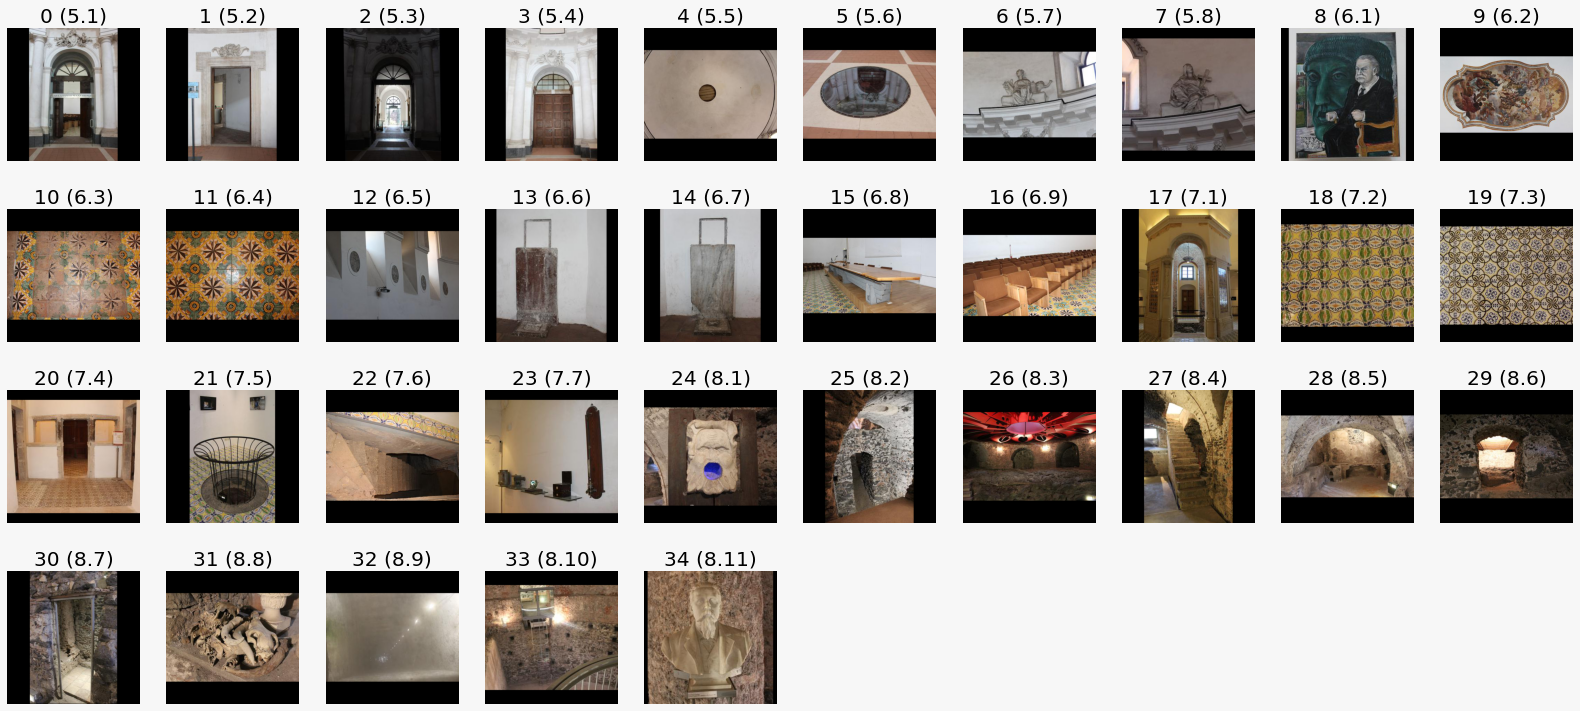

In [12]:
showSupportImages(dataset_supports_df, n_rows=4, n_cols=10)

In [0]:
def showTargetImages(targets_df, n_rows=5, n_cols=5):
  fig = plt.figure(figsize=(45, 10))
  fig.patch.set_alpha(0)
  gs = fig.add_gridspec(n_rows+1, n_cols)
  
  ax = fig.add_subplot(gs[0, 0])
  ax.imshow(resizeImg(targets_df['Support Path'].iloc[0]))
  ax.axis('off')
  ax.set_title('Class '+str(targets_df['Class'].iloc[0]), fontdict = {'fontsize' : 16}, color='white')
        
  r = 0
  c = 1

  for idx, row in targets_df.iterrows():
    ax = fig.add_subplot(gs[r, c])
    c+=1
    if c == n_cols:
        c=1
        r+=1
    ax.imshow(resizeImg(row['Target Path']))
    ax.axis('off')
    ax.set_title(row['Target Path'].split('Test/')[1], fontdict = {'fontsize' : 8}, color='grey')
  plt.show()

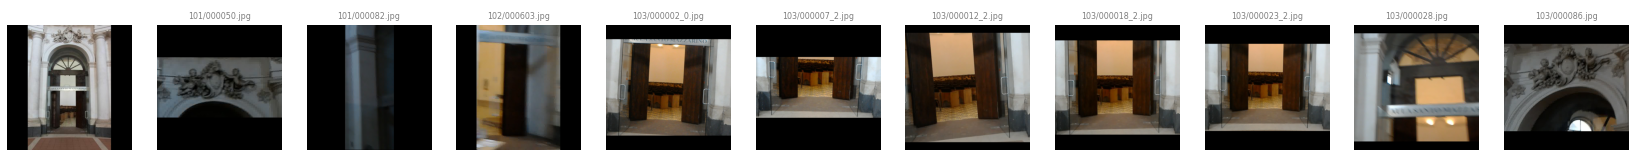

__________________________________________________________________________________________________________________________________________________________________________________________________________________


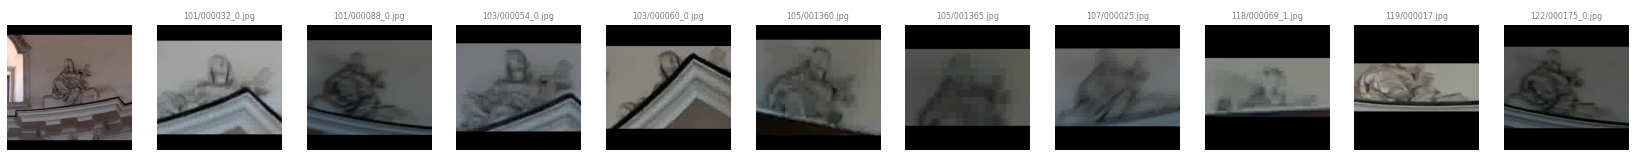

__________________________________________________________________________________________________________________________________________________________________________________________________________________


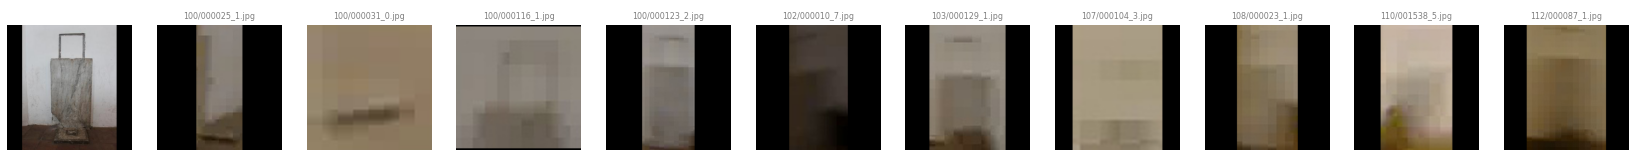

__________________________________________________________________________________________________________________________________________________________________________________________________________________


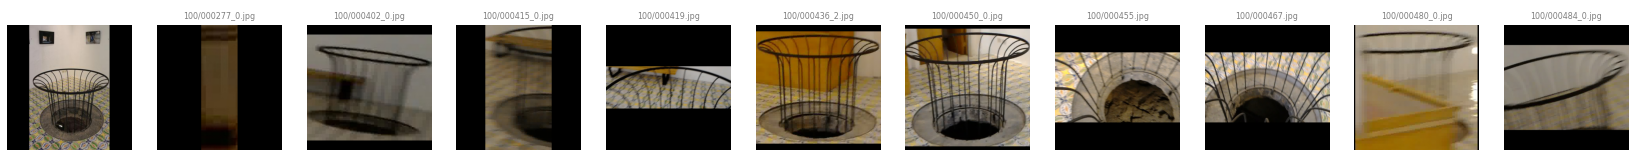

__________________________________________________________________________________________________________________________________________________________________________________________________________________


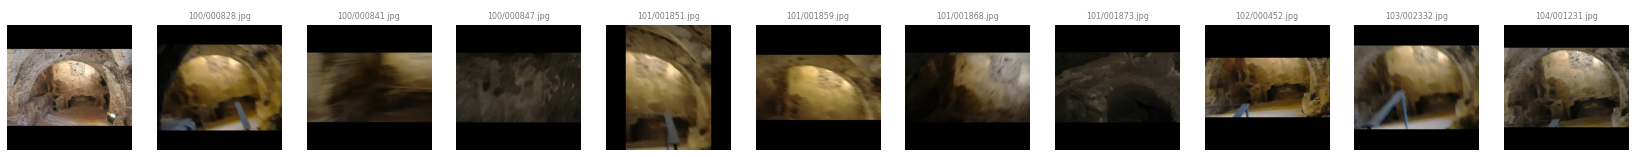

__________________________________________________________________________________________________________________________________________________________________________________________________________________


In [14]:
# Visualizziamo i sample di 5 delle 35 classi procendendo a passo 7
for i in range(0, 35, 7):
  # Visualizziamo 10 sample procedendo a passo 5
  sample = 10
  step = 5
  df = dataset_targets_df[dataset_targets_df['Class'] == i][:sample*step:step]
  showTargetImages(df, n_rows=1, n_cols=19)
  print('_'*210)

Come possiamo notare dai sample estratti, alcune immagini target risultano non essere buone al fine di allenare una rete neurale.<br>
In particolare possiamo notare la presenza di immagini **molto sfocate** o con relativamente **pochi dettagli** o a **tinta unita**, immagini con **scarsa risoluzione** e **valori di aspect rateo eccessivamente grandi o eccessivamente piccoli**.<br>
Calcoliamo separatamente per ciascuna immagine di classe i seguenti valori:
- Numero totale di pixel nell'immagine
- Rapporto larghezza/altezza immagine
- Deviazione standard dell'immagine convertita in scala di grigi
- Focus measure immagine (calcolata come varianza del filtro Laplaciano) al fine di eliminare le immagini eccessivamente sfocate

In [15]:
import cv2
from tqdm import tqdm

pbar = tqdm(total=len(dataset_targets_df))
dataset_params = {}

for i in range(35):
  class_params = {'pixels_count': [], 'rateo': [], 'devst': [], 'fm': []}

  for target_path in dataset_targets_df[dataset_targets_df['Class'] == i]['Target Path']:
    img = cv2.imread(target_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_height, img_width, _ = img.shape
    max_shape = max(img_height, img_width)
    min_shape = min(img_height, img_width)
    
    class_params['pixels_count'].append(img_height * img_width)
    class_params['rateo'].append(max_shape/float(min_shape))

    mean, devst = cv2.meanStdDev(img_gray)

    class_params['devst'].append(devst.item(0))

    # Compute the Laplacian of the image and return the focus measure, which is simply the variance of the Laplacian
    fm = cv2.Laplacian(img, cv2.CV_64F).var()

    class_params['fm'].append(fm)
    pbar.update(1)

  dataset_params[i] = class_params

100%|█████████▉| 44970/44978 [23:18<00:00, 46.23it/s]

In [16]:
from statistics import mean 

attributes = ['Pixels Count',	'Rateo', 'DevSt', 'FM']
subattributes = ['Min', 'Max', 'Mean']

dataset_params_df = pd.DataFrame(dataset_params).transpose()
A = np.array(sum([[attribute]*len(subattributes) for attribute in attributes], []))
B = np.array(subattributes*len(attributes))
C = [
     # pixels_count
     [int(min(class_list)) for class_list in dataset_params_df['pixels_count']], #min
     [int(max(class_list)) for class_list in dataset_params_df['pixels_count']], #min
     [int(mean(class_list)) for class_list in dataset_params_df['pixels_count']], #mean
     
     # rateo
     [int(min(class_list)) for class_list in dataset_params_df['rateo']], #min
     [int(max(class_list)) for class_list in dataset_params_df['rateo']], #min
     [int(mean(class_list)) for class_list in dataset_params_df['rateo']], #mean

     # devst
     [int(min(class_list)) for class_list in dataset_params_df['devst']], #min
     [int(max(class_list)) for class_list in dataset_params_df['devst']], #min
     [int(mean(class_list)) for class_list in dataset_params_df['devst']], #mean
     
     # fm
     [int(min(class_list)) for class_list in dataset_params_df['fm']], #min
     [int(max(class_list)) for class_list in dataset_params_df['fm']], #min
     [int(mean(class_list)) for class_list in dataset_params_df['fm']], #mean
]

C = np.array(C)
dataset_params_df = pd.DataFrame(data=C.T, columns=pd.MultiIndex.from_tuples(zip(A,B)))
dataset_params_df.index.name = 'Class'
dataset_params_df = dataset_params_df.transpose()
dataset_params_df

Class                   0        1       2   ...       32       33       34
Pixels Count Min      1836    42412   24700  ...     6030    10767     4136
             Max   1106967  1103544  845376  ...  1106000  1110123  1092000
             Mean   656512   445528  227133  ...   448253   783173   158561
Rateo        Min         1        1       1  ...        1        1        1
             Max         8        5       4  ...       17        9        8
             Mean        1        1       1  ...        2        1        1
DevSt        Min         6       20      11  ...        4        4       10
             Max        84       72      74  ...       68       66       47
             Mean       55       52      38  ...       23       36       24
FM           Min         4        4       5  ...        1        1        7
             Max       121       90     157  ...       98      105      143
             Mean       31       21      47  ...       12       26       38

[12 rows x 35 columns]

Raggrupperemo adesso i dati per poterli visualizzare separatamente tramite grafici

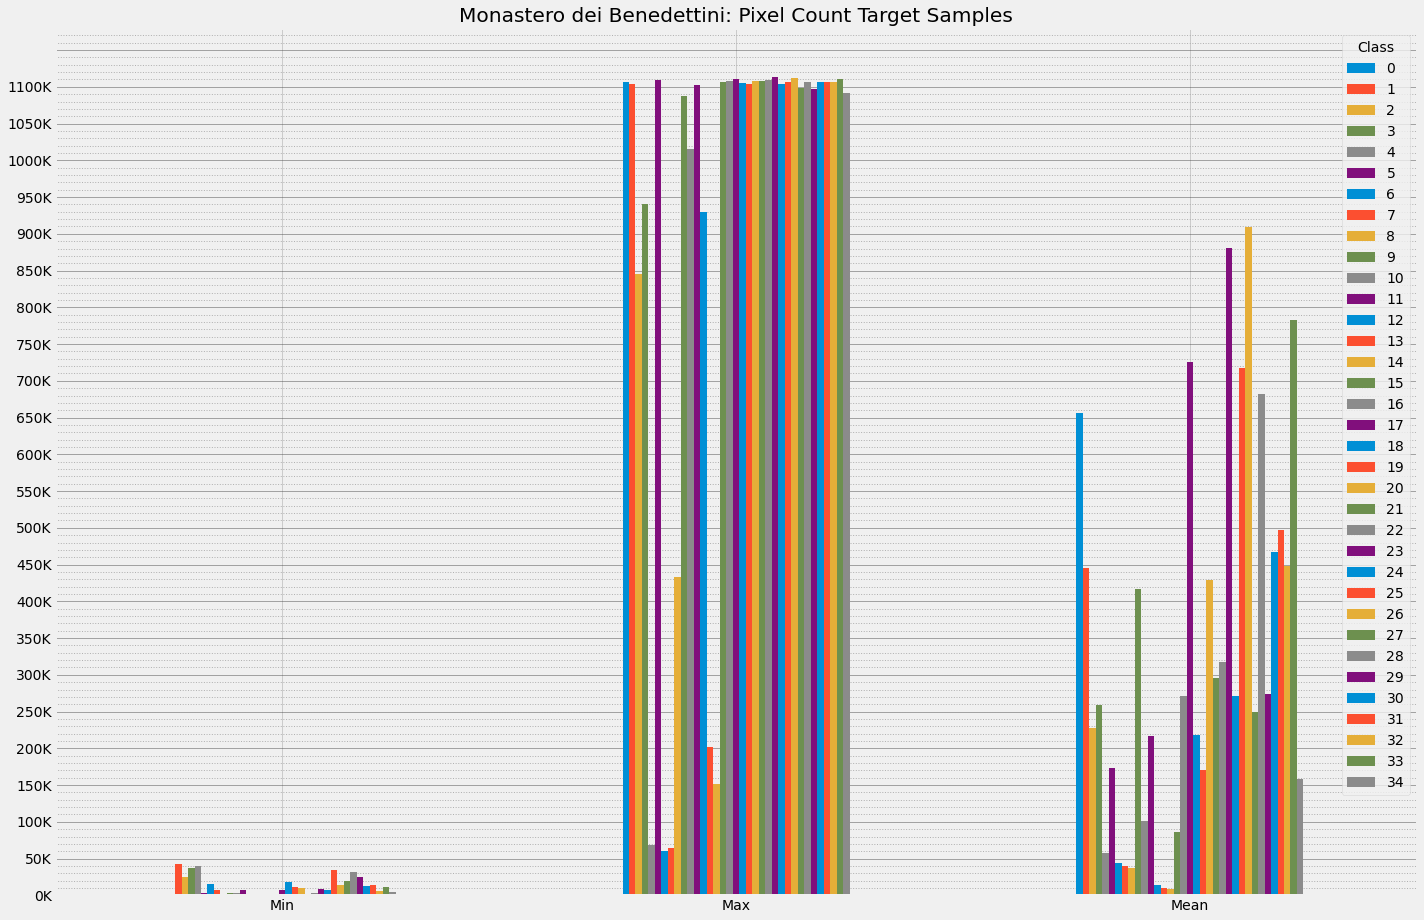

In [17]:
frequencyPlot(
    data=dataset_params_df.loc['Pixels Count']/1000,
    title="Monastero dei Benedettini: Pixel Count Target Samples",
    ytick_labels = [ str(value)+'K' for value in range(0, 1150, 50)],
    ytick_major_step=50,
    ytick_minor_step=10,
    max_val=1190
)

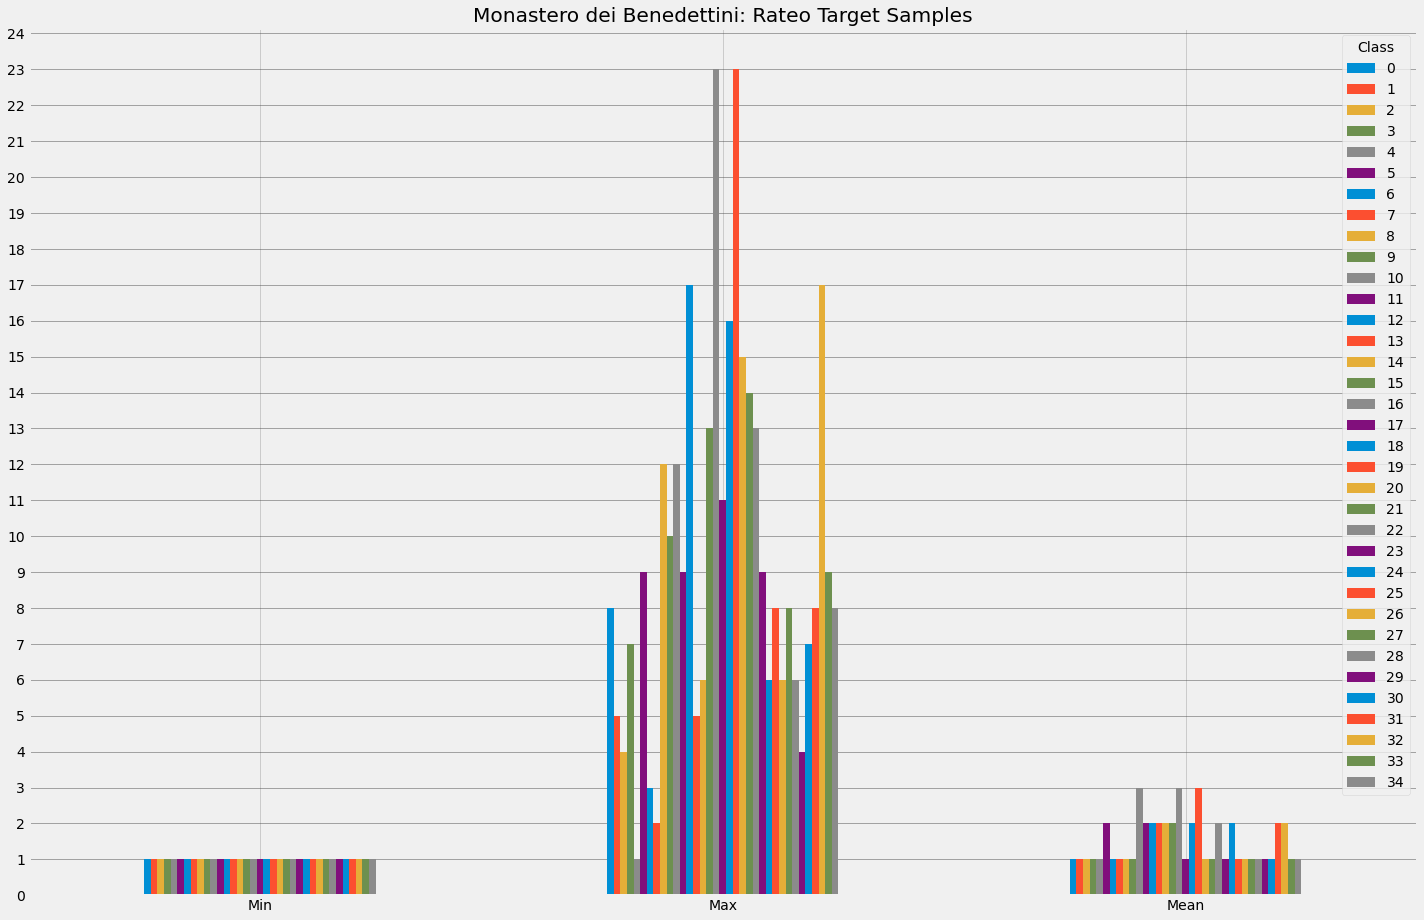

In [18]:
frequencyPlot(
    data=dataset_params_df.loc['Rateo'],
    title="Monastero dei Benedettini: Rateo Target Samples",
    ytick_major_step=1,
    ytick_minor_step=1,
    max_val=25
)

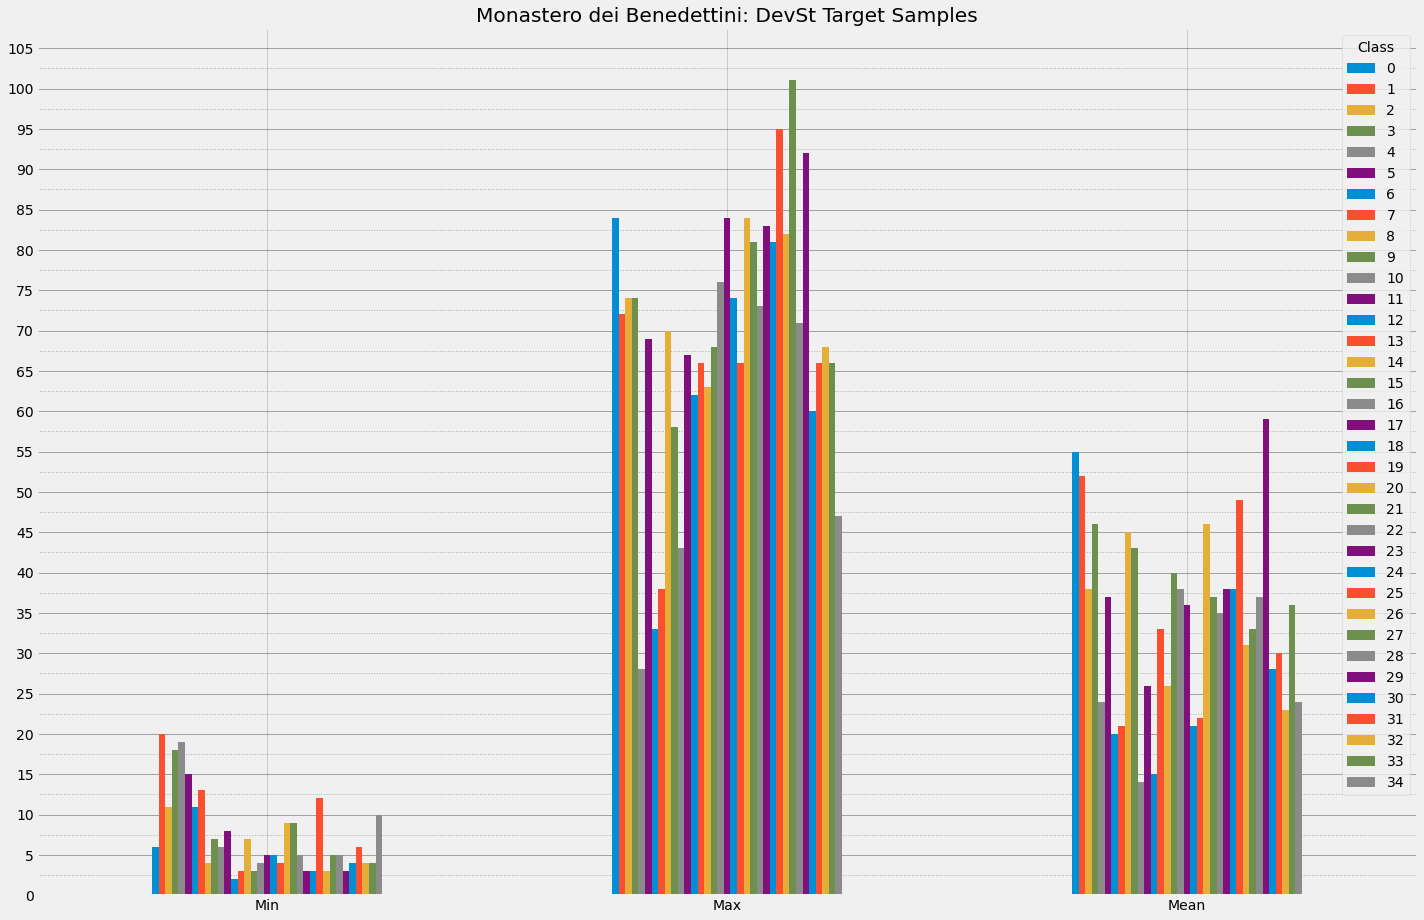

In [19]:
frequencyPlot(
    data=dataset_params_df.loc['DevSt'],
    title="Monastero dei Benedettini: DevSt Target Samples",
    ytick_major_step=5,
    ytick_minor_step=2.5,
    max_val=110
)

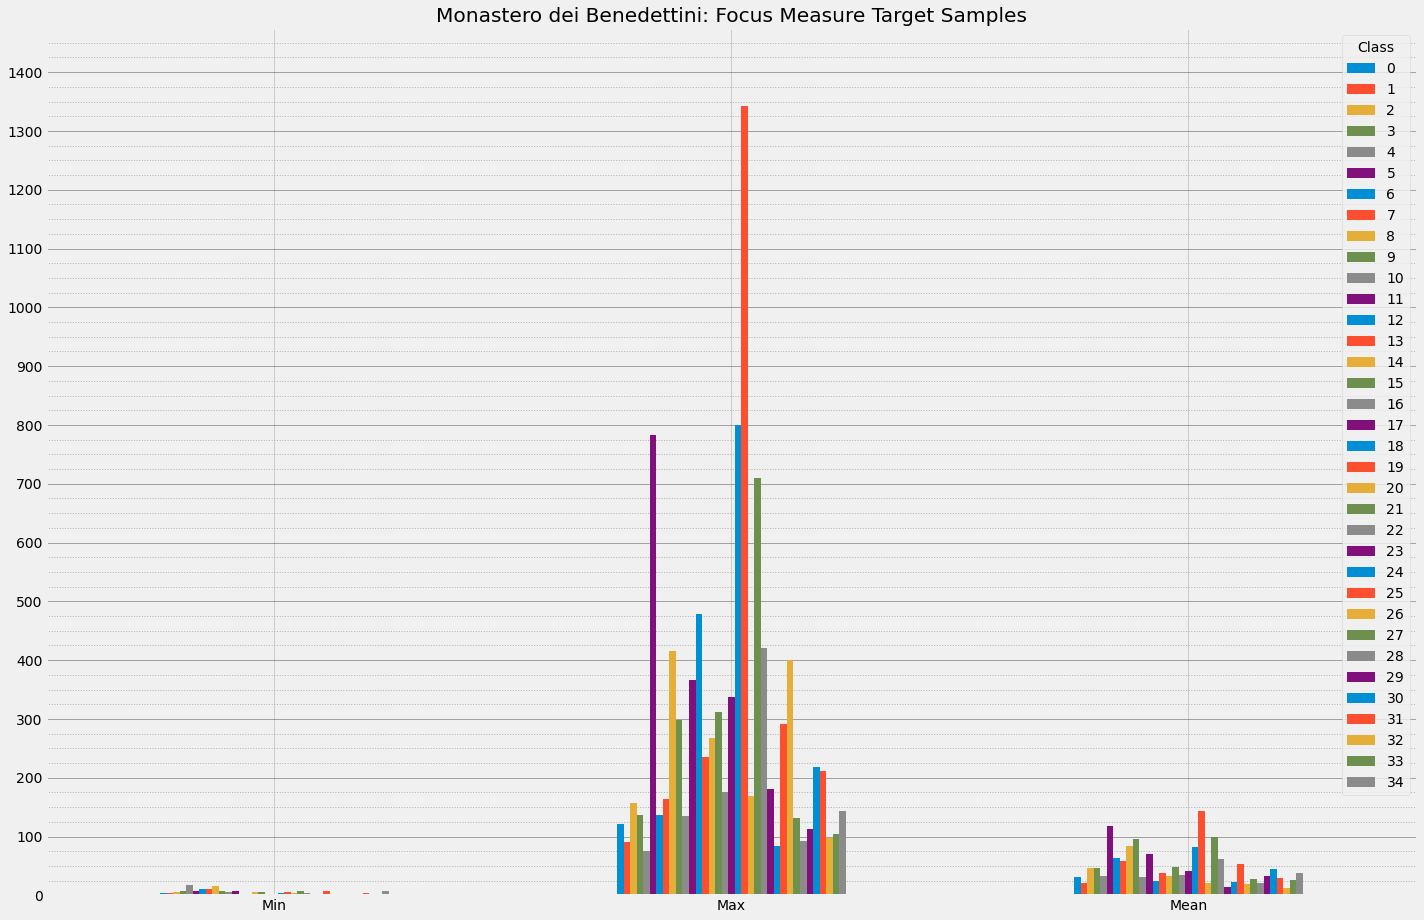

In [20]:
frequencyPlot(
    data=dataset_params_df.loc['FM'],
    title="Monastero dei Benedettini: Focus Measure Target Samples",
    ytick_major_step=100,
    ytick_minor_step=25,
    max_val=1500
)

Verifichiamo adesso tramite il metodo `describe` le statistiche relative a minimo, massimo e media di '*Min*', '*Max*', '*Mean*' di ciascun parametro analizzato.<br><br>
Avremo quindi per ciascun parametro:
- Minimo dei minimi
- Massimo dei minimi
- Media dei minimi
- Minimo della media
- Massimo della media
- Media della media
- Minimo dei massimi
- Massimo dei massimi
- Media dei massimi




In [21]:
dataset_params_df.transpose().describe()

Pixels Count                ...           FM            
                Min           Max  ...          Max        Mean
count     35.000000  3.500000e+01  ...    35.000000   35.000000
mean   12312.285714  9.240607e+05  ...   291.371429   47.571429
std    12275.925228  3.602337e+05  ...   264.592037   30.679832
min      390.000000  6.072200e+04  ...    76.000000   12.000000
25%     2934.000000  9.784080e+05  ...   133.000000   27.000000
50%     7605.000000  1.103988e+06  ...   181.000000   38.000000
75%    16599.000000  1.107448e+06  ...   352.000000   60.500000
max    42412.000000  1.112760e+06  ...  1342.000000  143.000000

[8 rows x 12 columns]

Concentriamoci esclusivamente sui valori medi

In [22]:
pd.DataFrame(dataset_params_df.transpose().describe().loc['mean'])

mean
Pixels Count Min    12312.285714
             Max   924060.657143
             Mean  330293.828571
Rateo        Min        1.000000
             Max        9.542857
             Mean       1.485714
DevSt        Min        7.314286
             Max       69.114286
             Mean      34.171429
FM           Min        4.942857
             Max      291.371429
             Mean      47.571429

Basandoci sui grafici, sulle statistiche ma principalmente da prove di filtraggio e verifica diretta sulle immagini filtrate sono stati fissati i seguenti parametri come sogli di filtraggio:

- **Minimo numero di pixel**: 7396 (86*86);
- **Massimo rateo**: 4;
- **Minima Deviazione Standard**: 6;
- **Minima Focus Measure**: 10;

Considerando la dimensione del dataset, filtreremo lo stesso dividendo il carico di lavoro su **8 thread** distinti.

In [0]:
from numpy import genfromtxt
from os import path, listdir
import cv2
import pickle
from threading import Thread, Lock
from random import sample
from math import ceil
from shutil import copy

class BenedettiniFilter():

    class FilterThread(Thread):
        def __init__(self, targets_dir, supports_dir, supports_df, subset, filter_function, copy_filtered=False):
            Thread.__init__(self)
            self.targets_dir = targets_dir
            self.supports_dir = supports_dir
            self.supports_df = supports_df
            self.subset = subset
            self.filter_function = filter_function
            self._return = None
            self.copy_filtered = copy_filtered
        
        def run(self):
            filtered_subset_list = []

            for folder_name in self.subset:
                try:
                    images_dir = path.join(self.targets_dir, str(folder_name))
                    target_labels = genfromtxt(path.join(self.targets_dir, 'labels/%d.txt' % folder_name))
                    target_images = listdir(images_dir)
                    target_images.sort()
            
                    if len(target_labels) != len(target_images):
                        raise Exception("error labels and images num are not the same!")

                    for index, target_path in enumerate(target_images):
                        target_img_path = path.join(str(folder_name), target_path)
                        target_class = int(target_labels[index])

                        target_img_path = path.join(self.targets_dir, target_img_path)
                        if not self.filter_function(target_img_path):
                            support_img_path = path.join(self.supports_dir, self.supports_df.loc[target_class]['Support Path'])
                            filtered_subset_list.append((target_img_path, target_class, support_img_path))
                        elif self.copy_filtered:
                            destination = r"E:/Sources/Repos/filtered-benedettini/filtered/"+str(folder_name)+'_'+path.basename(target_img_path)
                            copy(target_img_path, destination)

                except Exception as ex:
                    print(ex)

            self._return = filtered_subset_list

        def join(self, *args):
            Thread.join(self, *args)
            return self._return

    def __init__(self, targets_dir, supports_dir, supports_df, num_thread=8):
        self.targets_dir = targets_dir
        self.supports_dir = supports_dir
        self.supports_df = supports_df

        self.num_thread = num_thread

        folders_name_range = set(range(100, 166+1))
        #since some folders are missing, remove them from set
        missing_folders_name = {106, 127, 128, 131, 133, 141, 163}
        self.folders_set = folders_name_range - missing_folders_name

        self.run()
        self.join()

    def run(self):
        # Return a list of num_thread folder_subset
        self.folder_subset = self.computeThreadSubset(self.num_thread)
        
        # Create and run threads
        self.filter_threads = [None] * self.num_thread
        for i in range(self.num_thread):
            self.filter_threads[i] = self.FilterThread(self.targets_dir, self.supports_dir, self.supports_df, self.folder_subset[i], self.check_filter)
            self.filter_threads[i].start()

    def saveResults(self, filtered_list):
        pickle_out = open("filtered_target_list.pickle","wb")
        pickle.dump(filtered_list, pickle_out)
        pickle_out.close()

    def join(self):
        filtered_list = []

        for i in range(self.num_thread):
            filtered_subset_list = self.filter_threads[i].join()
            filtered_list += filtered_subset_list

        self.saveResults(filtered_list)

    def check_filter(self, imagePath):
        image = cv2.imread(imagePath)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        _, std = cv2.meanStdDev(gray)
        height, width, _ = image.shape
        pixel_count = height*width
        max_shape = max(height, width)
        min_shape = min(height, width)
        rateo = max_shape/float(min_shape)
        laplacian_var  = cv2.Laplacian(image, cv2.CV_64F).var()

        if pixel_count < 86*86 or rateo > 4 or std[0][0] < 6 or laplacian_var < 10:
            return True

        return False

    def computeThreadSubset(self, num_thread):
        '''
        # Arguments
            num_thread: number of thread to use
        # Returns
            folder_subset: list of size (num_thread) containing folders name that each thread should work with
        '''
        # Make a copy to avoid distruction of the original set
        folders_set_tmp = self.folders_set.copy()

        #split set into num_thread subset of almost equals size
        folder_subset_len = ceil(len(folders_set_tmp) / num_thread)
        folder_subset = [None] * num_thread
        for i in range(num_thread):
            if i < num_thread-1:
                folder_subset[i] = set(sample(folders_set_tmp, folder_subset_len))
                folders_set_tmp -= folder_subset[i]
            else: #last set contains remaining folders
                folder_subset[i] = folders_set_tmp

        return folder_subset

In [24]:
b_filter = BenedettiniFilter(dataset_targets_path, dataset_supports_path, dataset_supports_df, num_thread = 8)

100%|██████████| 44978/44978 [23:30<00:00, 46.23it/s]

Carichiamo la nuova lista filtrata di target dal file "`.pickle`" prodotto e visualizziamoli tramite un `DataFrame`.

In [25]:
#!cp *.pickle "drive/My Drive/Datasets/BellomoBenedettini"
with (open("filtered_target_list.pickle", "rb")) as openfile:
  filtered_dataset_target_list = pickle.load(openfile)
  filtered_dataset_target_list.sort()
  filtered_dataset_target_df = pd.DataFrame(filtered_dataset_target_list)

filtered_dataset_target_df.columns = ("Target Path", "Class", "Support Path")
filtered_dataset_target_df

Target Path  ...                                       Support Path
0      dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
1      dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
2      dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
3      dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
4      dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
...                                                  ...  ...                                                ...
32789  dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
32790  dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
32791  dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
32792  dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...
32793  dataset/Object Retrieval/Monastero dei Benedet...  ...  dataset/Object Retrieval/Monastero dei Benedet...

[32794 rows x 3 columns]

Alla fine dell'operazione di filtraggio sono state mantenute nel dataset **32794** immagini target su **44978**.

In [0]:
filtered_dataset_class_samples_count_df = filtered_dataset_target_df["Class"].value_counts().sort_index().to_frame('Class filtered samples count')

Visualizziamo la nuova distribuzione sul dataset filtrato tramite grafico

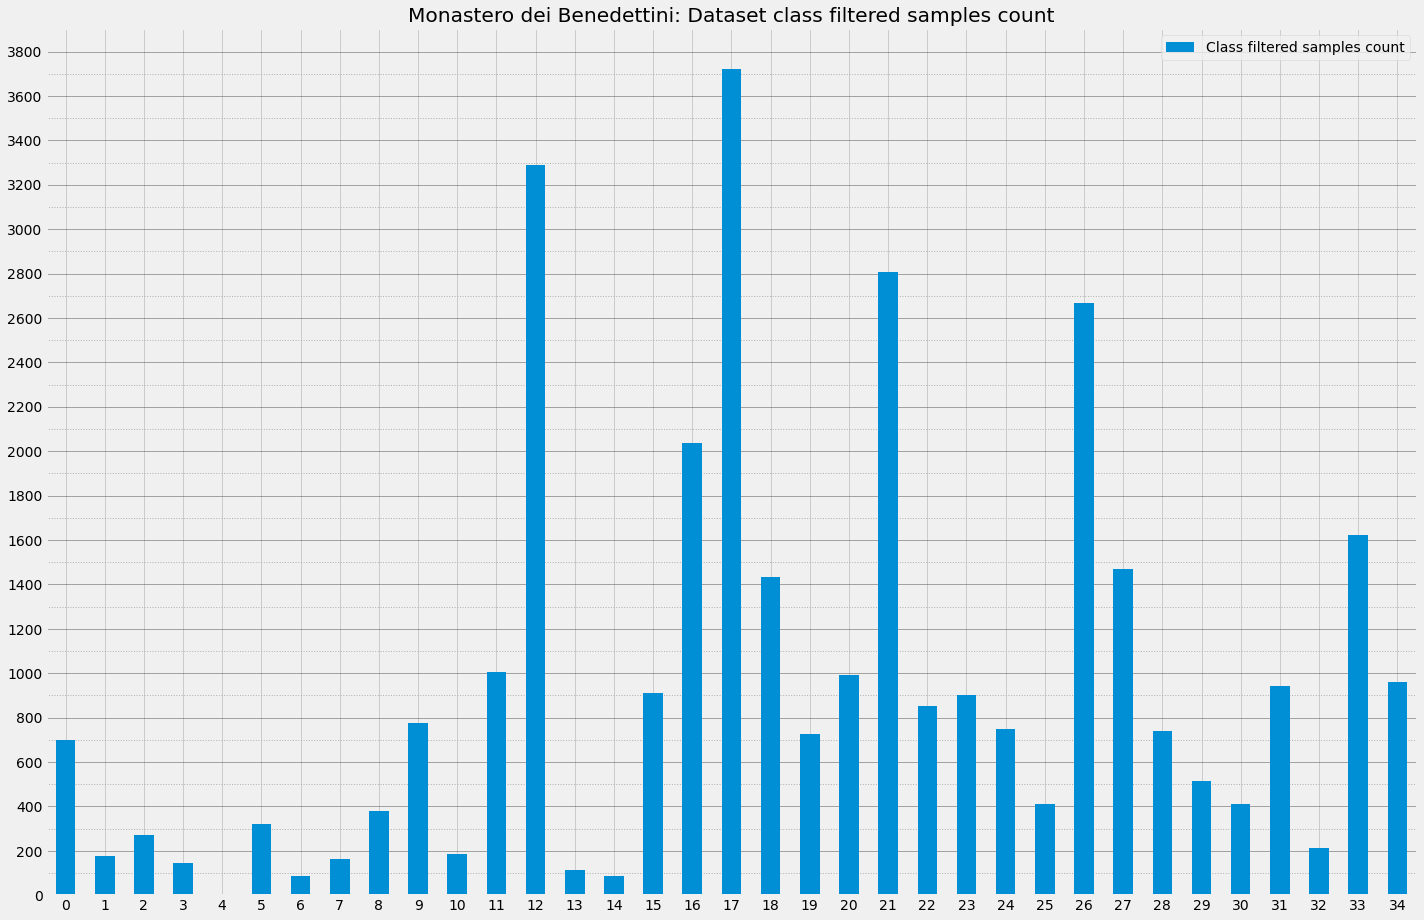

In [27]:
frequencyPlot(
    data=filtered_dataset_class_samples_count_df,
    title="Monastero dei Benedettini: Dataset class filtered samples count",
    ytick_major_step=200,
    ytick_minor_step=100,
    max_val=3850
)

Siamo adesso interessati a confrontare la numerosità di ciascuna classe prima e dopo aver effettuato il filtraggio 

In [28]:
dataset_class_samples_count_compare_df = pd.concat([original_dataset_class_samples_count_df, filtered_dataset_class_samples_count_df], axis=1)
dataset_class_samples_count_compare_df.transpose()

0    1    2    3   ...    31   32    33    34
Class original samples count  769  207  276  148  ...  1083  568  1760  1024
Class filtered samples count  698  179  271  145  ...   943  211  1621   959

[2 rows x 35 columns]

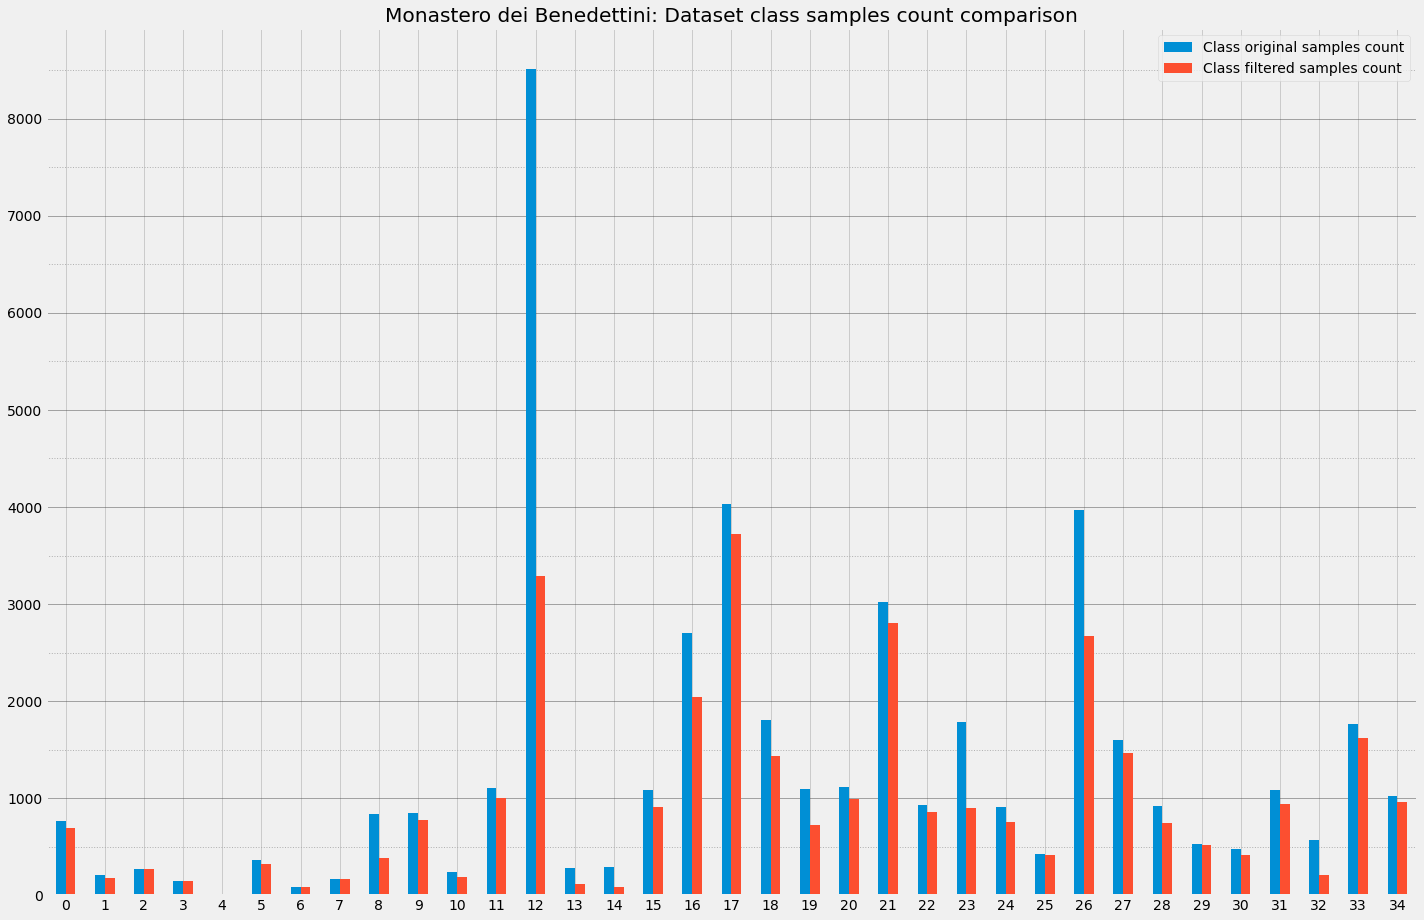

In [29]:
frequencyPlot(
    dataset_class_samples_count_compare_df,
    title="Monastero dei Benedettini: Dataset class samples count comparison",
    ytick_minor_step=500,
    ytick_major_step=1000
)

Vediamo adesso per ciascuna classe la percentuale di samples rispetto all'intero dataset sia originale che filtrato. 

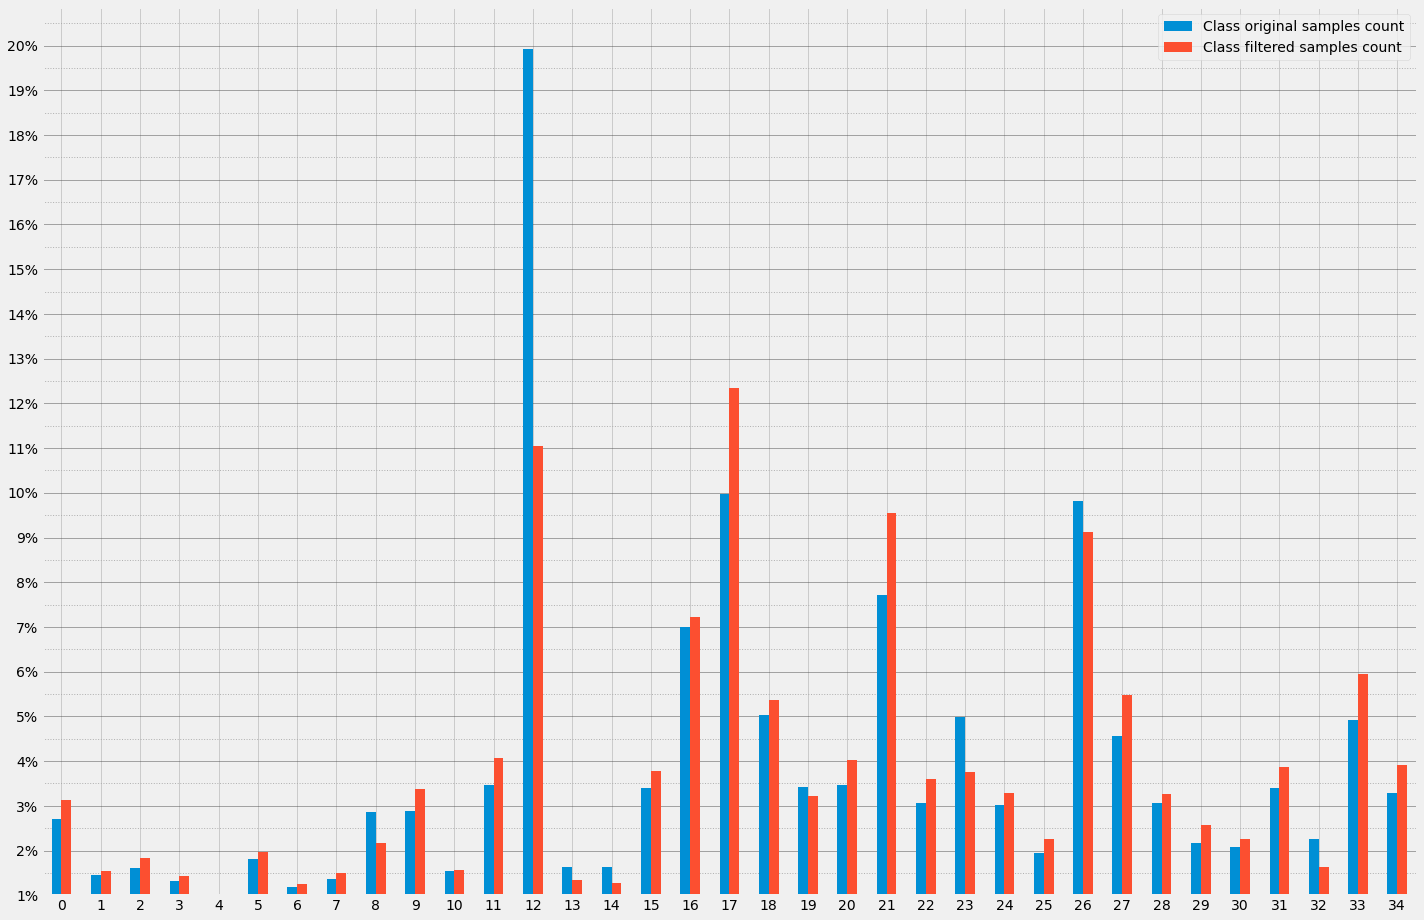

In [30]:
frequencyPlot(
    dataset_class_samples_count_compare_df / dataset_class_samples_count_compare_df.sum(),
    ytick_minor_step=0.005,
    ytick_major_step=0.01,
    ytick_labels = [ str(value)+'%' for value in range(1, 21)],
    max_val=0.2
)

Vedremo adesso alcune delle immagini del dataset che sono state mantenute dopo l'operazione di filtraggio.

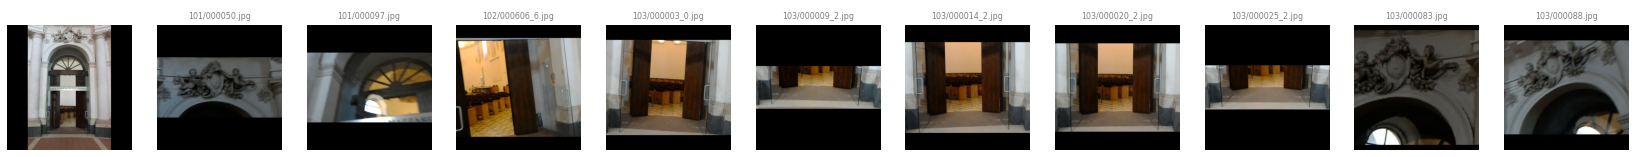

__________________________________________________________________________________________________________________________________________________________________________________________________________________


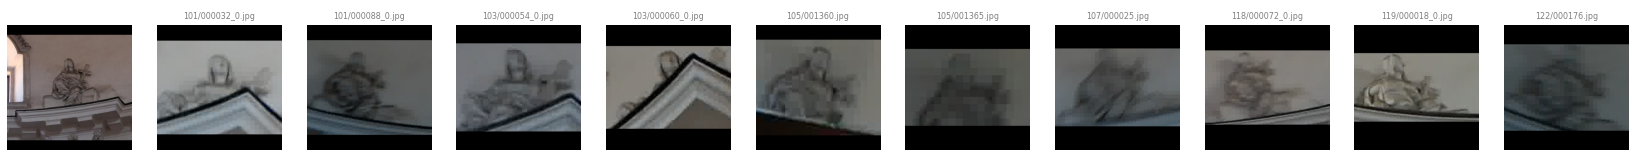

__________________________________________________________________________________________________________________________________________________________________________________________________________________


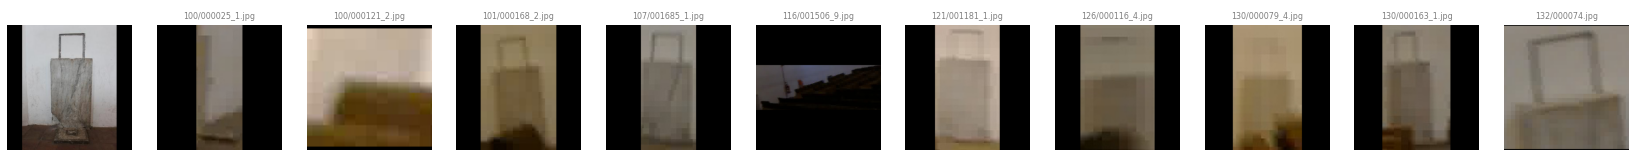

__________________________________________________________________________________________________________________________________________________________________________________________________________________


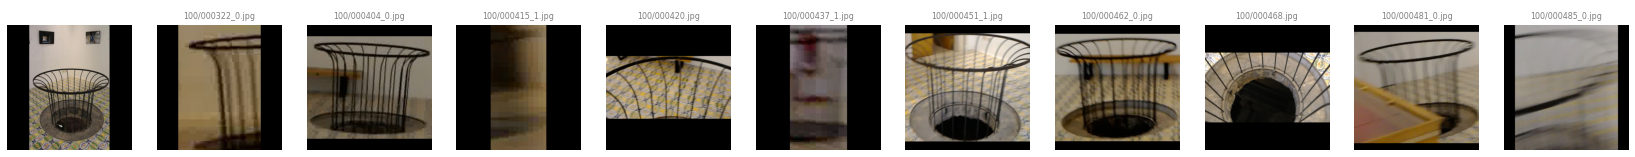

__________________________________________________________________________________________________________________________________________________________________________________________________________________


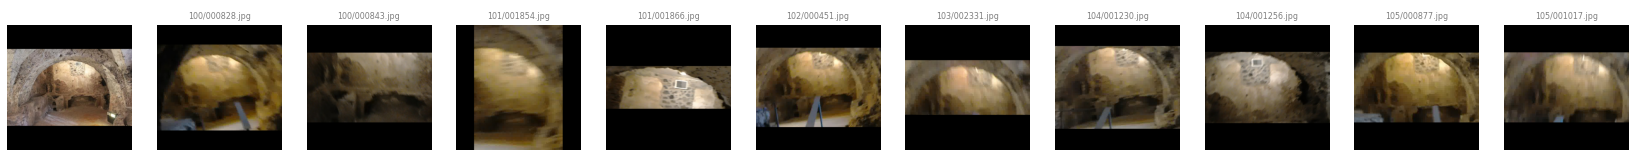

__________________________________________________________________________________________________________________________________________________________________________________________________________________


In [31]:
# Visualizziamo i sample di 5 delle 35 classi procendendo a passo 7
for i in range(0, 35, 7):
  # Visualizziamo 10 sample procedendo a passo 5
  sample = 10
  step = 5
  df = filtered_dataset_target_df[filtered_dataset_target_df['Class'] == i][:sample*step:step]
  showTargetImages(df, n_rows=1, n_cols=19)
  print('_'*210)

Basandoci sull'analisi effettuata abbiamo deciso di scartare alcune classi a causa di un'etichettatura poco accurata e di selezionato tra le classi rimanenti **12 classi** da usare come **training set** e **10 classi** da usare come **test set**

In [0]:
training = [0, 1, 7, 8, 11, 13, 15, 16, 17, 18, 24, 28]
test     = [2, 3, 6, 9, 10, 14, 19, 20, 29, 34]
sospese  = [4, 5, 21, 22, 25, 26, 27, 30, 31, 33]
scartare = [12, 23, 32]

Dopo aver effettuato dei test con il dataset filtrato in modo parametrico abbiamo deciso di creare un nuovo dataset di dimensioni ridotte filtrando manualmente le immagini migliori nelle quali l'oggetto interessato è interamente contenuto.
Per facilitare il lavoro di filtraggio manuale le immagini target sono state ripartite in 35 cartelle e in ciascuna cartella è stata inserita l'immagine support di riferimento.

La nuova struttura del dataset può essere riassunta nel seguente modo:

```
Dataset_Classes_HandFiltered/
├── 0/
│   ├── class_0.jpg
│   └── Keep/
│       ├── 000005_0.jpg
│       ├── ...
│       └── 001790.jpg
├── .../
│   ├── class_ ... .jpg
│   └── Keep/
│       ├── ...
│       └── ... .jpg
└── 34/
    ├── class_34.jpg
    └── Keep/
        ├── 000351.jpg
        ├── ...
        └── 001397.jpg
```

In [0]:
!cp "drive/My Drive/Datasets/BellomoBenedettini/Benedettini_Classes_HandFiltered.tar" dataset_classes_hand_filtered.tar

In [0]:
!tar -xf dataset_classes_hand_filtered.tar

In [0]:
hf_dataset_path = "Dataset_Classes_HandFiltered/"

In [0]:
from os import path, listdir
import numpy as np
import pandas as pd

def createTargetDataFrameFromHFDataset(target_dir):
  target_list = []
  for i in range(35):
    images_dir = path.join(target_dir, str(i))
    target_images_path = listdir(images_dir+'/keep')
    target_images_path.sort()

    for target_image_path in target_images_path:
      target_list.append((path.join(images_dir+'/keep', target_image_path), i, path.join(images_dir, 'class_'+str(i)+'.jpg')))

  dataset_target_df = pd.DataFrame(target_list)
  dataset_target_df.columns = ("Relative Path", "Class", "Support Path")
  return dataset_target_df

In [37]:
dataset_hand_filtered_target_df = createTargetDataFrameFromHFDataset(hf_dataset_path)
dataset_hand_filtered_target_df

Relative Path  ...                                  Support Path
0    Dataset_Classes_HandFiltered/0/keep/000005_0.jpg  ...    Dataset_Classes_HandFiltered/0/class_0.jpg
1    Dataset_Classes_HandFiltered/0/keep/000009_4.jpg  ...    Dataset_Classes_HandFiltered/0/class_0.jpg
2      Dataset_Classes_HandFiltered/0/keep/000891.jpg  ...    Dataset_Classes_HandFiltered/0/class_0.jpg
3    Dataset_Classes_HandFiltered/0/keep/000892_1.jpg  ...    Dataset_Classes_HandFiltered/0/class_0.jpg
4    Dataset_Classes_HandFiltered/0/keep/001281_1.jpg  ...    Dataset_Classes_HandFiltered/0/class_0.jpg
..                                                ...  ...                                           ...
415   Dataset_Classes_HandFiltered/34/keep/000742.jpg  ...  Dataset_Classes_HandFiltered/34/class_34.jpg
416   Dataset_Classes_HandFiltered/34/keep/000871.jpg  ...  Dataset_Classes_HandFiltered/34/class_34.jpg
417   Dataset_Classes_HandFiltered/34/keep/000931.jpg  ...  Dataset_Classes_HandFiltered/34/class_34.jpg
418   Dataset_Classes_HandFiltered/34/keep/000993.jpg  ...  Dataset_Classes_HandFiltered/34/class_34.jpg
419   Dataset_Classes_HandFiltered/34/keep/001397.jpg  ...  Dataset_Classes_HandFiltered/34/class_34.jpg

[420 rows x 3 columns]

Anche in questo caso, visualizziamo il grafico relativo alla numerosità dei sample di ciascuna classe ed infine alcune immagini del dataset filtrato manualmente.

In [38]:
hand_filtered_dataset_samples_count_df = dataset_hand_filtered_target_df["Class"].value_counts().sort_index().to_frame('Class hand filtered samples count').transpose()
hand_filtered_dataset_samples_count_df

0   1   2   3   4   ...  30  31  32  33  34
Class hand filtered samples count  10  16  13   9   8  ...  10  10  11  10  13

[1 rows x 35 columns]

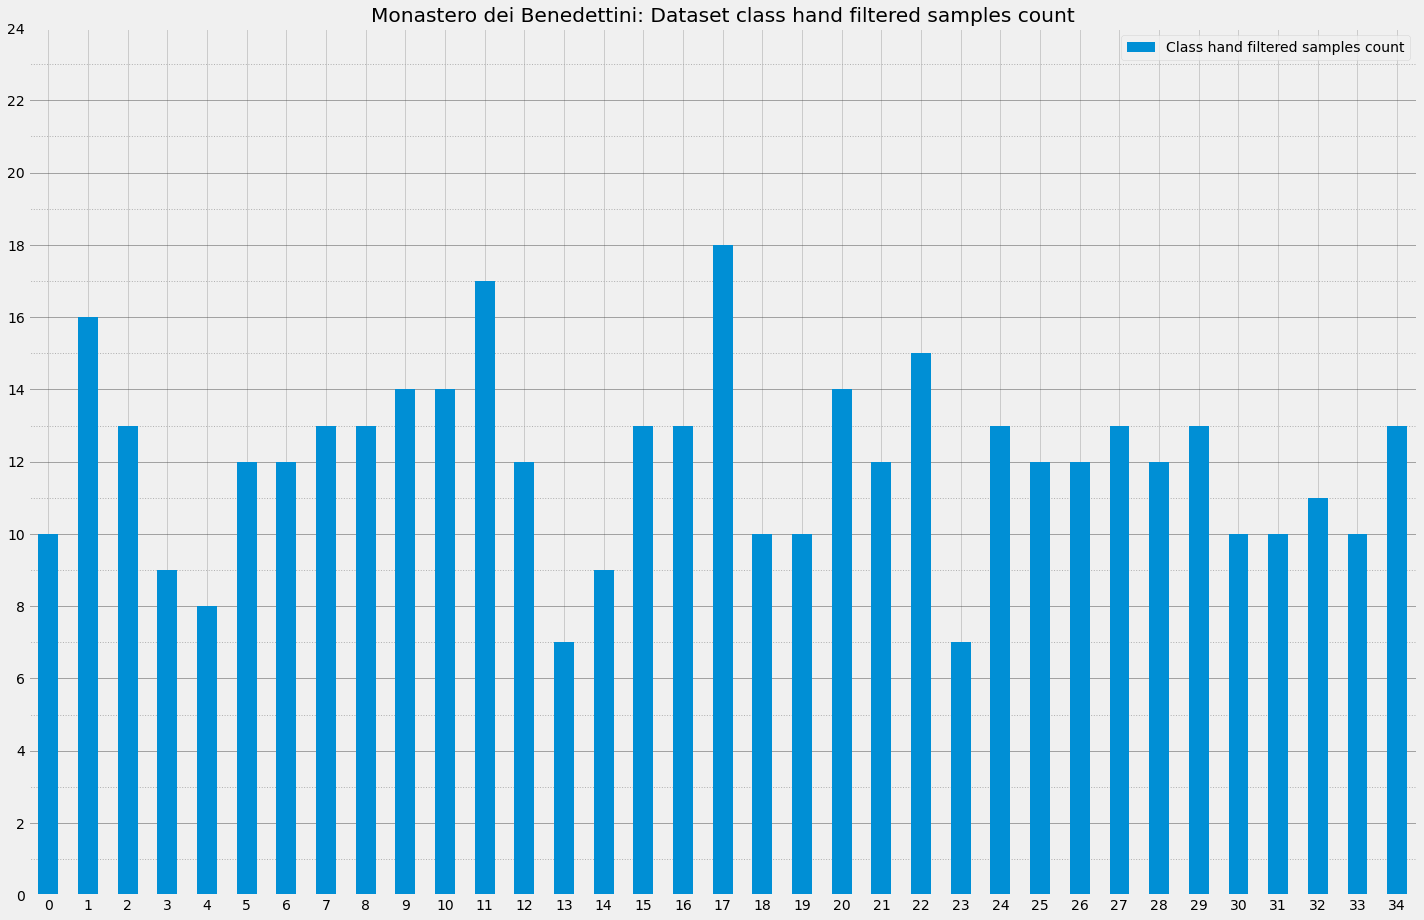

In [39]:
frequencyPlot(
    data=hand_filtered_dataset_samples_count_df.transpose(),
    title="Monastero dei Benedettini: Dataset class hand filtered samples count",
    ytick_major_step=2,
    ytick_minor_step=1,
    max_val=25
)

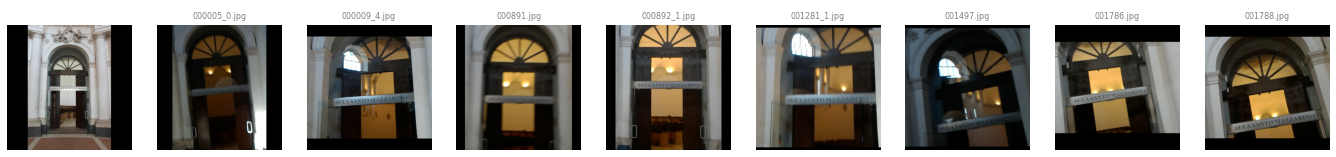

**************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


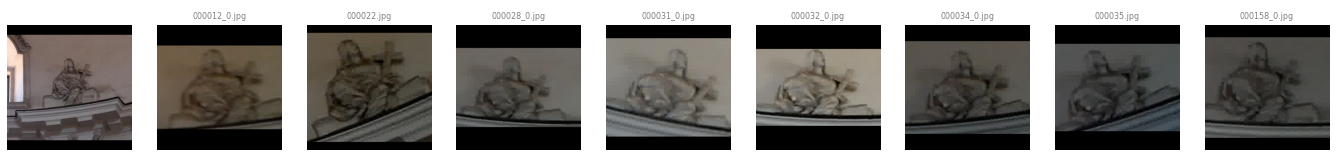

**************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


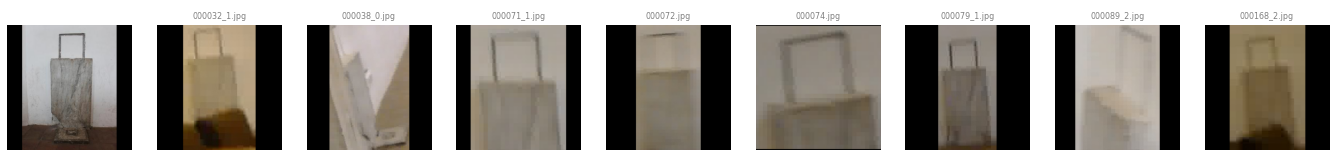

**************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


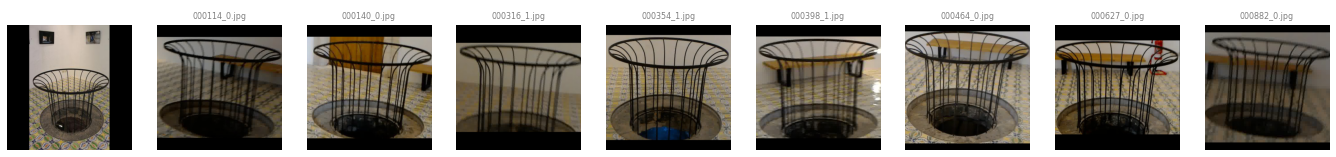

**************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


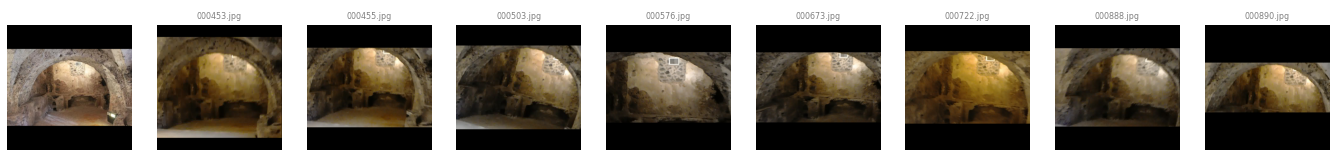

**************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


In [40]:
from PIL import Image
import math

def show_hand_filtered_dataset(df, n_rows=5, n_cols=5):
  fig = plt.figure(figsize=(45, 10))
  fig.patch.set_alpha(0)
  gs = fig.add_gridspec(n_rows+1, n_cols)
  
  ax = fig.add_subplot(gs[0, 0])
  ax.imshow(resizeImg(df['Support Path'].iloc[0]))
  ax.axis('off')
  ax.set_title('Class '+str(df['Class'].iloc[0]), fontdict = {'fontsize' : 16}, color='white')
        
  r = 0
  c = 1

  for idx, row in df.iterrows():
    ax = fig.add_subplot(gs[r, c])
    c+=1
    if c == n_cols:
        c=1
        r+=1
    ax.imshow(resizeImg(row['Relative Path']))
    ax.axis('off')
    ax.set_title(row['Relative Path'].split('keep/')[1], fontdict = {'fontsize' : 8}, color='grey')
  plt.show()

for i in range(0, 35, 7):
  df = dataset_hand_filtered_target_df[dataset_hand_filtered_target_df['Class'] == i][:8]
  show_hand_filtered_dataset(df, n_rows=1, n_cols=19)
  print('_'*350)

# Risultati
---
\
Dopo aver effettuato l'analisi ed il filtraggio finora descritto abbiamo riscontrato un leggeto aumento del 5% sull'accuracy utilizzando il dataset filtrato automaticamente utilizzando i parametri ottenuti dall'analisi effettuata.
Come ci aspettavamo, utilizzando invece il dataset filtrato a mano le performance sono salite parecchio, ma probabilmente hanno semplificato eccessivamente il problema a tal punto che durante tutta la fase di training non è stato registrato nessun apprendimento da parte del modello.

![alt text](https://i.ibb.co/QXC7cRg/Immagine.png)

I risultati ottenuti con le varie versioni del dataset possono essere visualizzati nel seguente [link](https://teams.microsoft.com/l/file/6DEC90C3-A3D1-4245-9D0D-6D12D65A0F98?tenantId=baeefbc8-3c8b-4382-9126-e86bfef46ce6&fileType=xlsx&objectUrl=https%3A%2F%2Fstudentiunict.sharepoint.com%2Fsites%2FOne-ShotLearningforObjectRecognitioninCulturalSites%2FShared%20Documents%2FGeneral%2FRisultati.xlsx&baseUrl=https%3A%2F%2Fstudentiunict.sharepoint.com%2Fsites%2FOne-ShotLearningforObjectRecognitioninCulturalSites&serviceName=teams&threadId=19:0c9ad4ba03f847dcab845fc4aff819c1@thread.tacv2&groupId=cfc381ec-717a-467b-a4c6-7283fd256095).